In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('../data/city_day.csv')

# Clean column names
df.columns = df.columns.str.lower().str.replace('.', '_', regex=False)
df.head()


,city,datetime,pm2_5,pm10,no,no2,nox,nh3,co,so2,o3,benzene,toluene,xylene,aqi,aqi_bucket
0,Delhi,2015-01-01,153.3,241.7,182.9,33.0,81.3,38.5,1.87,64.5,83.6,18.93,20.81,8.32,204.5,Severe
1,Mumbai,2015-01-01,70.5,312.7,195.0,42.0,122.5,31.5,7.22,83.8,108.0,2.01,19.41,2.86,60.9,Satisfactory
2,Chennai,2015-01-01,174.1,275.4,56.2,68.8,230.9,28.5,8.56,60.8,43.9,19.07,10.19,9.63,486.5,Severe
3,Kolkata,2015-01-01,477.2,543.9,14.1,76.4,225.9,45.6,2.41,42.1,171.1,9.31,11.65,9.39,174.4,Very Poor
4,Bangalore,2015-01-01,171.6,117.7,123.3,12.4,61.9,49.7,1.26,79.7,164.3,6.04,12.74,9.59,489.7,Good


In [ ]:
import importlib
import diffusion_model
importlib.reload(diffusion_model)

print(dir(diffusion_model))
from diffusion_model import Simple1DDiffusionModel
print(X_train.shape)  # Should be (num_samples, sequence_length)
print(y_train.shape)  # Should be (num_samples, 1)


✅ diffusion_model.py is being loaded
['Simple1DDiffusionModel', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'nn', 'torch']
(2898, 30)
(2898, 1)


Shape: (18265, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18265 entries, 0 to 18264
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        18265 non-null  object 
 1   datetime    18265 non-null  object 
 2   pm2_5       18265 non-null  float64
 3   pm10        18265 non-null  float64
 4   no          18265 non-null  float64
 5   no2         18265 non-null  float64
 6   nox         18265 non-null  float64
 7   nh3         18265 non-null  float64
 8   co          18265 non-null  float64
 9   so2         18265 non-null  float64
 10  o3          18265 non-null  float64
 11  benzene     18265 non-null  float64
 12  toluene     18265 non-null  float64
 13  xylene      18265 non-null  float64
 14  aqi         18265 non-null  float64
 15  aqi_bucket  18265 non-null  object 
dtypes: float64(13), object(3)
memory usage: 2.2+ MB


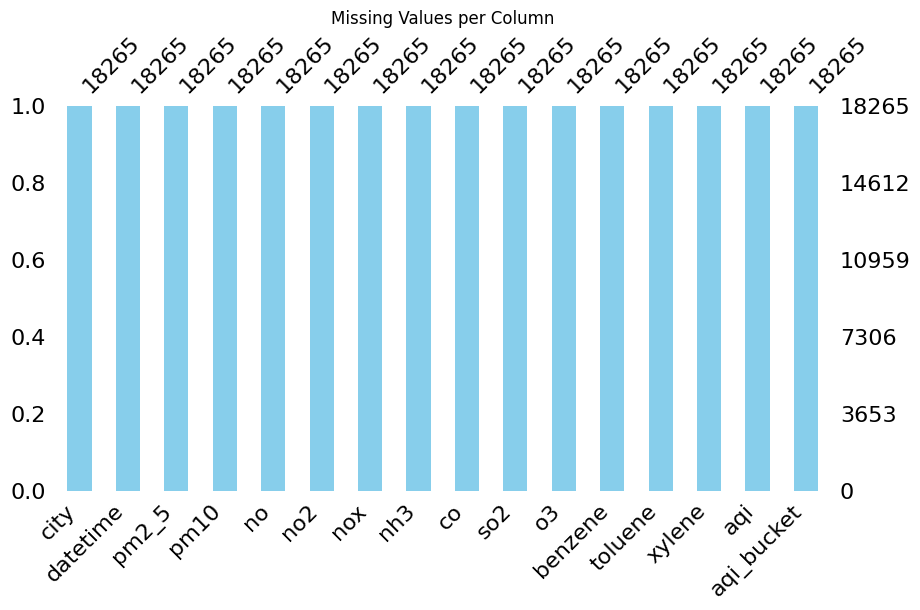

In [ ]:
print("Shape:", df.shape)
df.info()

# Install if needed
# !pip install missingno

import missingno as msno
msno.bar(df, figsize=(10, 5), color="skyblue")
plt.title("Missing Values per Column")
plt.show()



In [61]:
df['city'].value_counts().head(10)  # List top cities


city
Delhi        3653
Mumbai       3653
Chennai      3653
Kolkata      3653
Bangalore    3653
Name: count, dtype: int64

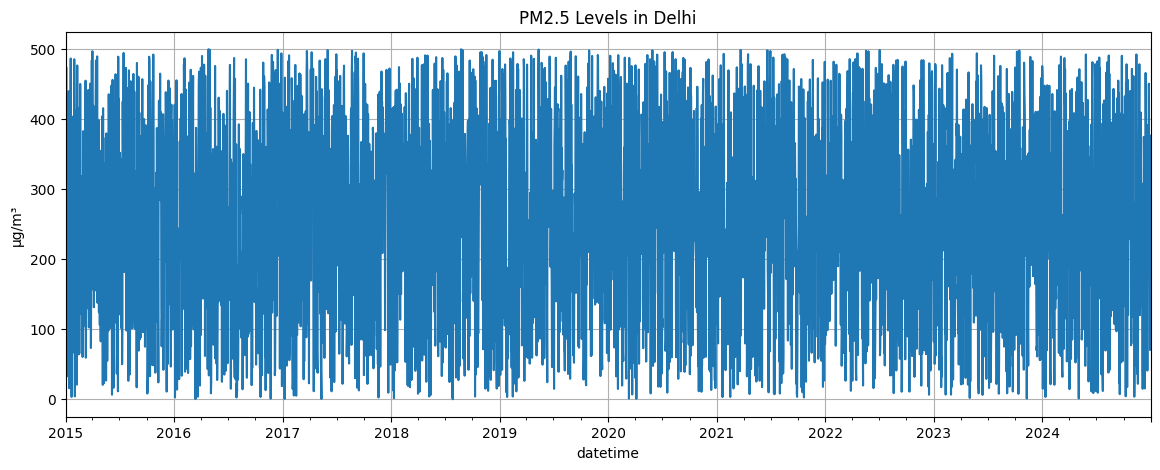

In [62]:
city_df = df[df['city'] == 'Delhi'].copy()
city_df['datetime'] = pd.to_datetime(city_df['datetime'])
city_df = city_df.sort_values('datetime')
city_df.set_index('datetime', inplace=True)

# Drop rows where pm2_5 is missing
city_df = city_df[~city_df['pm2_5'].isna()]

# Plot
plt.figure(figsize=(14, 5))
city_df['pm2_5'].plot(title='PM2.5 Levels in Delhi')
plt.ylabel('µg/m³')
plt.grid(True)
plt.show()


In [63]:
# Check % of missing values in all columns
missing_percent = city_df.isna().mean() * 100
print(missing_percent)

# Fill missing values with forward then backward fill
city_df = city_df.ffill().bfill()


city          0.0
pm2_5         0.0
pm10          0.0
no            0.0
no2           0.0
nox           0.0
nh3           0.0
co            0.0
so2           0.0
o3            0.0
benzene       0.0
toluene       0.0
xylene        0.0
aqi           0.0
aqi_bucket    0.0
dtype: float64


C:\Users\ASus\AppData\Local\Temp\ipykernel_23600\2481772225.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = city_df['pm2_5'].resample('M').mean()


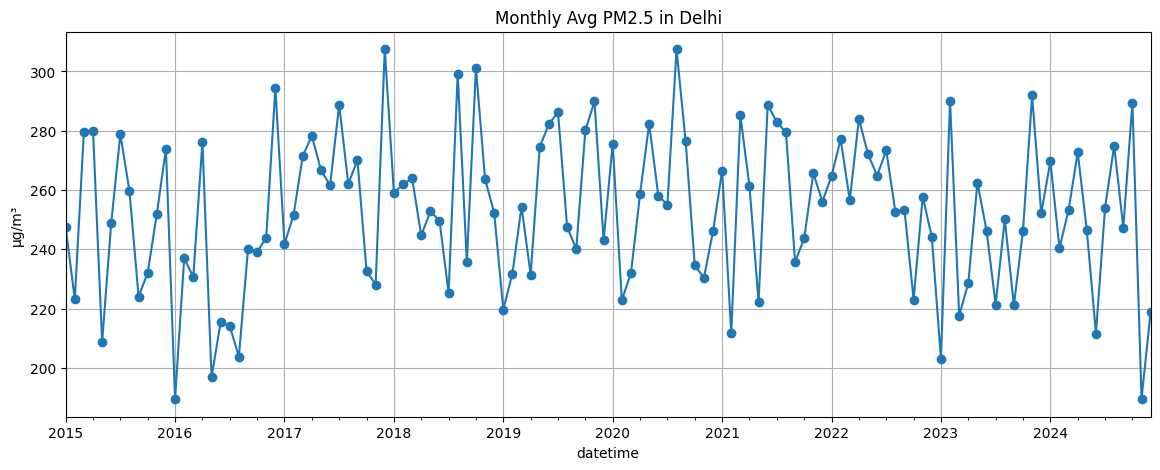

In [64]:
# Resample to monthly
monthly_df = city_df['pm2_5'].resample('M').mean()

# Plot
plt.figure(figsize=(14, 5))
monthly_df.plot(title='Monthly Avg PM2.5 in Delhi', marker='o')
plt.ylabel('µg/m³')
plt.grid(True)
plt.show()


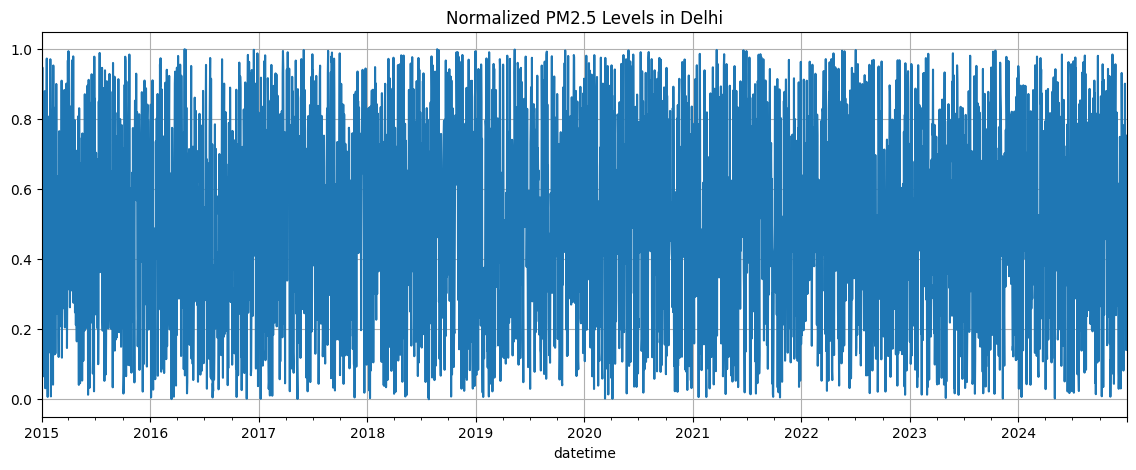

In [65]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
pm_scaled = scaler.fit_transform(city_df[['pm2_5']])

# Save as DataFrame with datetime index
pm_scaled_df = pd.DataFrame(pm_scaled, index=city_df.index, columns=['pm2_5'])

# Plot scaled version
plt.figure(figsize=(14, 5))
pm_scaled_df['pm2_5'].plot(title='Normalized PM2.5 Levels in Delhi')
plt.grid(True)
plt.show()


In [66]:
import numpy as np

def create_sequences(data, input_len=30, output_len=1):
    X, y = [], []
    for i in range(len(data) - input_len - output_len + 1):
        X.append(data[i:i + input_len])
        y.append(data[i + input_len:i + input_len + output_len])
    return np.array(X), np.array(y)

# Create sequences
input_len = 30   # past 30 days
output_len = 1   # predict next day
X, y = create_sequences(pm_scaled_df['pm2_5'].values, input_len, output_len)

print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (3623, 30), y shape: (3623, 1)


In [67]:
# 80-20 split
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]


In [68]:
import torch
import torch.nn as nn

# Move to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

model = Simple1DDiffusionModel(seq_len=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 30
batch_size = 64

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_t.size(0))
    
    for i in range(0, X_train_t.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = X_train_t[indices]
        batch_y = y_train_t[indices]

        optimizer.zero_grad()
        output = model(batch_x)
        loss = loss_fn(output[:, -1:], batch_y)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.6f}")


Epoch 1/30 - Loss: 0.059883
Epoch 2/30 - Loss: 0.093917
Epoch 3/30 - Loss: 0.078962
Epoch 4/30 - Loss: 0.101280
Epoch 5/30 - Loss: 0.082664
Epoch 6/30 - Loss: 0.089090
Epoch 7/30 - Loss: 0.080756
Epoch 8/30 - Loss: 0.078211
Epoch 9/30 - Loss: 0.084010
Epoch 10/30 - Loss: 0.077823
Epoch 11/30 - Loss: 0.062056
Epoch 12/30 - Loss: 0.089762
Epoch 13/30 - Loss: 0.065471
Epoch 14/30 - Loss: 0.064910
Epoch 15/30 - Loss: 0.090491
Epoch 16/30 - Loss: 0.087529
Epoch 17/30 - Loss: 0.075524
Epoch 18/30 - Loss: 0.043618
Epoch 19/30 - Loss: 0.058639
Epoch 20/30 - Loss: 0.076531
Epoch 21/30 - Loss: 0.058166
Epoch 22/30 - Loss: 0.089242
Epoch 23/30 - Loss: 0.048723
Epoch 24/30 - Loss: 0.072919
Epoch 25/30 - Loss: 0.057026
Epoch 26/30 - Loss: 0.034664
Epoch 27/30 - Loss: 0.047830
Epoch 28/30 - Loss: 0.061989
Epoch 29/30 - Loss: 0.038668
Epoch 30/30 - Loss: 0.072617


In [69]:
model.eval()
with torch.no_grad():
    preds = model(X_train_t).cpu().numpy()[:, -1]  # last value in each sequence
    true = y_train_t.cpu().numpy().flatten()


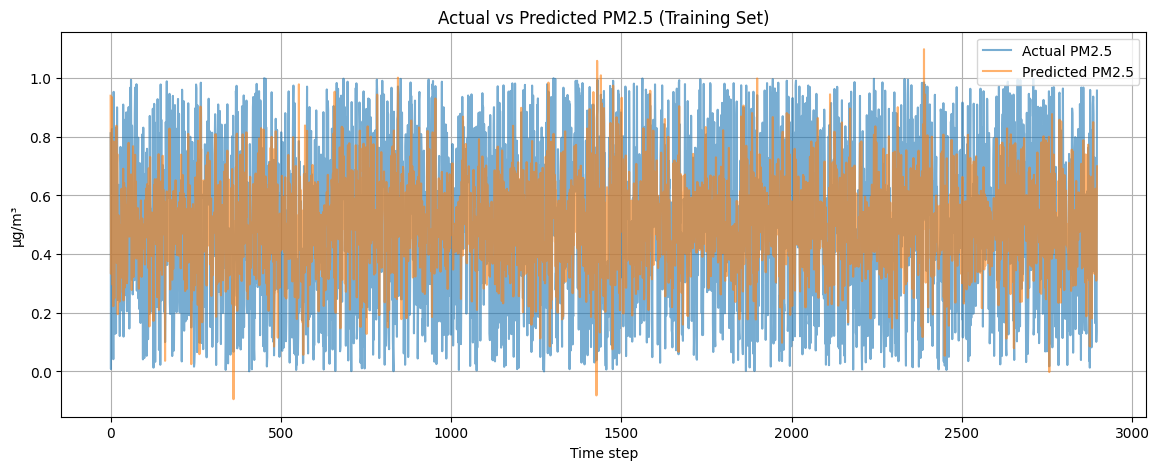

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(true, label='Actual PM2.5', alpha=0.6)
plt.plot(preds, label='Predicted PM2.5', alpha=0.6)
plt.title('Actual vs Predicted PM2.5 (Training Set)')
plt.xlabel('Time step')
plt.ylabel('µg/m³')
plt.legend()
plt.grid(True)
plt.show()


In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

print(f"📉 MSE: {mse:.4f}")
print(f"📉 MAE: {mae:.4f}")


📉 MSE: 0.0464
📉 MAE: 0.1780


In [85]:
# Save model
torch.save(model.state_dict(), '../models/pm25_diffusion_model.pth')
print("Model saved to models/pm25_diffusion_model.pth")


Model saved to models/pm25_diffusion_model.pth


In [81]:
# Assuming your cleaned dataframe is called `city_df`
city_df.to_csv('../data/processed_city_data.csv')


In [84]:
city_df_reset.rename(columns={"datetime": "Date"}, inplace=True)
city_df_reset.to_csv('../data/processed_city_data.csv', index=False)
